In [1]:
# a script for making pretty plots

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import csv as csv

from sklearn import linear_model, datasets

%matplotlib inline

In [154]:
# function for loading one data-set
def load_data(folder_path, idx, image, channel_id):
    # image = 'N2_dpy-23_ex_int_ama-1_015'
    path = folder_path + '/c' + str(channel_id) + "/"
    # file = 'N2_dpy-23_ex_int_ama-1_015.nd2 - N2_dpy-23_ex_int_ama-1_015.nd2 (series ' + str(idx).zfill(2) + ').tif.csv'
    file = image + '.nd2 - ' + image + '.nd2 (series ' + str(idx).zfill(2) + ') - C=' + str(channel_id - 1) + '.csv'
    
    data = np.loadtxt(path + file, delimiter = '\t')
    z = data[:, 3]
    I = data[:, 4]
    
    return (z, I)

In [4]:
# returns the y coordinate for the given line
# y = kx + b; also works with vectors
def f_x(x_, k_, b_):
    return k_*x_ + b_

In [5]:
def ransac_fit(I, z):
    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(z.reshape(-1,1), I)
    # inlier_mask = ransac.inlier_mask_
    
    # Predict data of estimated models
    line_X = np.arange(z.reshape(-1,1).min(), z.reshape(-1,1).max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    # The slope of the line
    # print(ransac.estimator_.coef_[0], ransac.estimator_.intercept_)
    lines_params[idx - 1, :] = [ransac.estimator_.coef_[0], ransac.estimator_.intercept_]
    
    # fixing the slope here
    # return k, b; last 2 are for the visualizations
    return (lines_params[idx - 1, 0], lines_params[idx - 1, 1], line_X, line_y_ransac)

In [135]:
def linear_fit(I, z):
    # Fit linear model
    lr = linear_model.LinearRegression()
    lr.fit(z.reshape(-1,1), I)
    
    idx = 1
    
    # Predict data of estimated models
    line_X = np.arange(z.reshape(-1,1).min(), z.reshape(-1,1).max())[:, np.newaxis]
    line_y_lr = lr.predict(line_X)
    
    # The slope of the line
    lines_params[idx - 1, :] = [lr.coef_[0], lr.intercept_]
    
    # fixing the slope here
    # return k, b; last 2 are for the visualizations
    return (lines_params[idx - 1, 0], lines_params[idx - 1, 1], line_X, line_y_lr)

In [7]:
# returns the adjusted intensity values
def perform_correction(I, z, k, b):
    z_min_arg = z.argmin()

    dI = f_x(z.min(), k, b) - f_x(z, k, b)  
    I_adj = I + dI 
    
    return (I_adj)

In [129]:
# general setup for pretty images 
num_files = 16
lines_params = np.zeros([num_files, 2])
channel_id = 1 # 1,2,3
folder_path = '/Volumes/Samsung_T3/2017-08-24-intronic-probes/' 
image = 'N2_dpy-23_ex_int_ama-1_016'
Ia_min, Ia_max = 0, 40000
za_min, za_max = 0, 55

In [130]:
def plot_fitting(I, I_adj, z, idx, line_X, line_y):
    ax = plt.subplot(num_files, 2, 2*idx - 1);
    # plt.title(image + ' (series ' + str(idx).zfill(2) + ').tif', fontsize = 40)
    plt.xlabel('$z$')
    plt.ylabel('$I_{0}$')
    plt.grid(which='major', axis='both', linestyle='dashed')
    plt.axis([za_min, za_max, Ia_min, Ia_max])

    plt.plot(z, I, 'ro', label='mRNA')
    # plt.plot(z.reshape(-1,1)[inlier_mask], I[inlier_mask],  'go')
        
    plt.setp(ax.get_xticklabels()[0], visible=False)    
    plt.setp(ax.get_yticklabels()[0], visible=False)
    
    plt.plot(line_X, line_y, color='cornflowerblue', linewidth=4, label='Fit')
    plt.legend(loc='upper right')
    
    ax = plt.subplot(num_files, 2, 2*idx);
    # plt.title(image + ' (series ' + str(idx).zfill(2) + ').tif', fontsize = 40)
    plt.xlabel('$z$')
    plt.ylabel('$I_{0}$')
    plt.grid(which='major', axis='both', linestyle='dashed')
    plt.axis([za_min, za_max, Ia_min, Ia_max])

    plt.plot(z, I_adj, 'ro', label='mRNA')
    
    plt.setp(ax.get_xticklabels()[0], visible=False)    
    plt.setp(ax.get_yticklabels()[0], visible=False)
    
    plt.legend(loc='upper right')

In [64]:
plt.figure(figsize=(40,100))
for idx in range (1, num_files + 1):
    # z, I = make_graphs(idx, image)   
    z, I = load_data(folder_path + image + '/results', idx, image, channel_id) 
    
    k, b, line_X, line_y = linear_fit(I, z)
    I_adj = perform_correction(I, z, k, b) 
 
    plot_fitting(I, I_adj, z, idx, line_X, line_y)
plt.savefig(image + 'spots C = ' + str(channel_id) + '.pdf')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Samsung_T3/2017-08-24-intronic-probes/N2_dpy-23_ex_int_ama-1_016/results/c1/N2_dpy-23_ex_int_ama-1_016.nd2 - N2_dpy-23_ex_int_ama-1_016.nd2 (series 01) - C=0.csv'

In [167]:
def plot_distribution(I, I_adj): 
    
    params = {'font.size'   : 42,
        'legend.fontsize': 52}
    plt.rcParams.update(params)
    
    ax = plt.subplot(num_files, 2, 2*idx - 1);
    # plt.title(image + ' (series ' + str(idx).zfill(2) + ').tif')
    plt.xlabel('$I_0$')
    plt.ylabel('$\#\, of \, mRNAs$')
    plt.axis([Ia_min, Ia_max, 0, 150])
    plt.grid(which='major', axis='both', linestyle='dashed')
    
    plt.setp(ax.get_xticklabels()[0], visible=False)    
    plt.setp(ax.get_yticklabels()[0], visible=False)
    
    plt.hist(I, bins=np.arange(min(I), max(I) + binwidth, binwidth), color=['red'])[2]
    
    ax = plt.subplot(num_files, 2, 2*idx);
    # plt.title(image + ' (series ' + str(idx).zfill(2) + ').tif')
    plt.xlabel('$I_0$')
    plt.ylabel('$\#\, of \, mRNAs$')
    plt.axis([Ia_min, Ia_max, 0, 150])
    plt.grid(which='major', axis='both', linestyle='dashed')
    
    plt.setp(ax.get_xticklabels()[0], visible=False)    
    plt.setp(ax.get_yticklabels()[0], visible=False)
    
    plt.hist(I_adj, bins=np.arange(min(I), max(I) + binwidth, binwidth), color=['red'])[2]

In [172]:
binwidth = 200
plt.figure(figsize=(40,100))
for idx in range (1, num_files + 1):
    z, I = load_data(folder_path + image + '/results', idx, image, channel_id) 
    
    k, b, line_X, line_y = linear_fit(I, z)
    I_adj = perform_correction(I, z, k, b) 
    
    plot_distribution(I, I_adj)
plt.savefig(image + ' hist C = ' + str(channel_id) + '.pdf')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Samsung_T3/2017-08-24-intronic-probes/N2_dpy-23_ex_int_ama-1_016/results/c1/N2_dpy-23_ex_int_ama-1_016.nd2 - N2_dpy-23_ex_int_ama-1_016.nd2 (series 01) - C=0.csv'

In [48]:
# function for loading one data-set
def count_total(folder_path, idx, image, channel_id):
    # image = 'N2_dpy-23_ex_int_ama-1_015'
    path = folder_path + '/c' + str(channel_id) + "/"
    # file = 'N2_dpy-23_ex_int_ama-1_015.nd2 - N2_dpy-23_ex_int_ama-1_015.nd2 (series ' + str(idx).zfill(2) + ').tif.csv'
    file = image + '.nd2 - ' + image + '.nd2 (series ' + str(idx).zfill(2) + ') - C=' + str(channel_id - 1) + '.csv'
    
    data = np.loadtxt(path + file, delimiter = '\t')
    z = data[:, 3]
    I = data[:, 4]
    
    return data[:, 0].shape[0]

In [160]:
num_files = 16
channel_id = 1 # 1,2,3
folder_path = '/Volumes/Samsung_T3/2017-08-24-intronic-probes/' 
image = 'N2_dpy-23_ex_int_ama-1_016'

for idx in range (1, num_files + 1):
    print (str(idx) + ', ' + str(count_total(folder_path + image + '/results', idx, image, channel_id)))

1, 1653
2, 1870
3, 1162
4, 195
5, 1660
6, 1375
7, 975
8, 1111
9, 1288
10, 1840
11, 3049
12, 1449
13, 615
14, 1451
15, 1376
16, 1925


In [65]:
# the set of results for one specific image

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


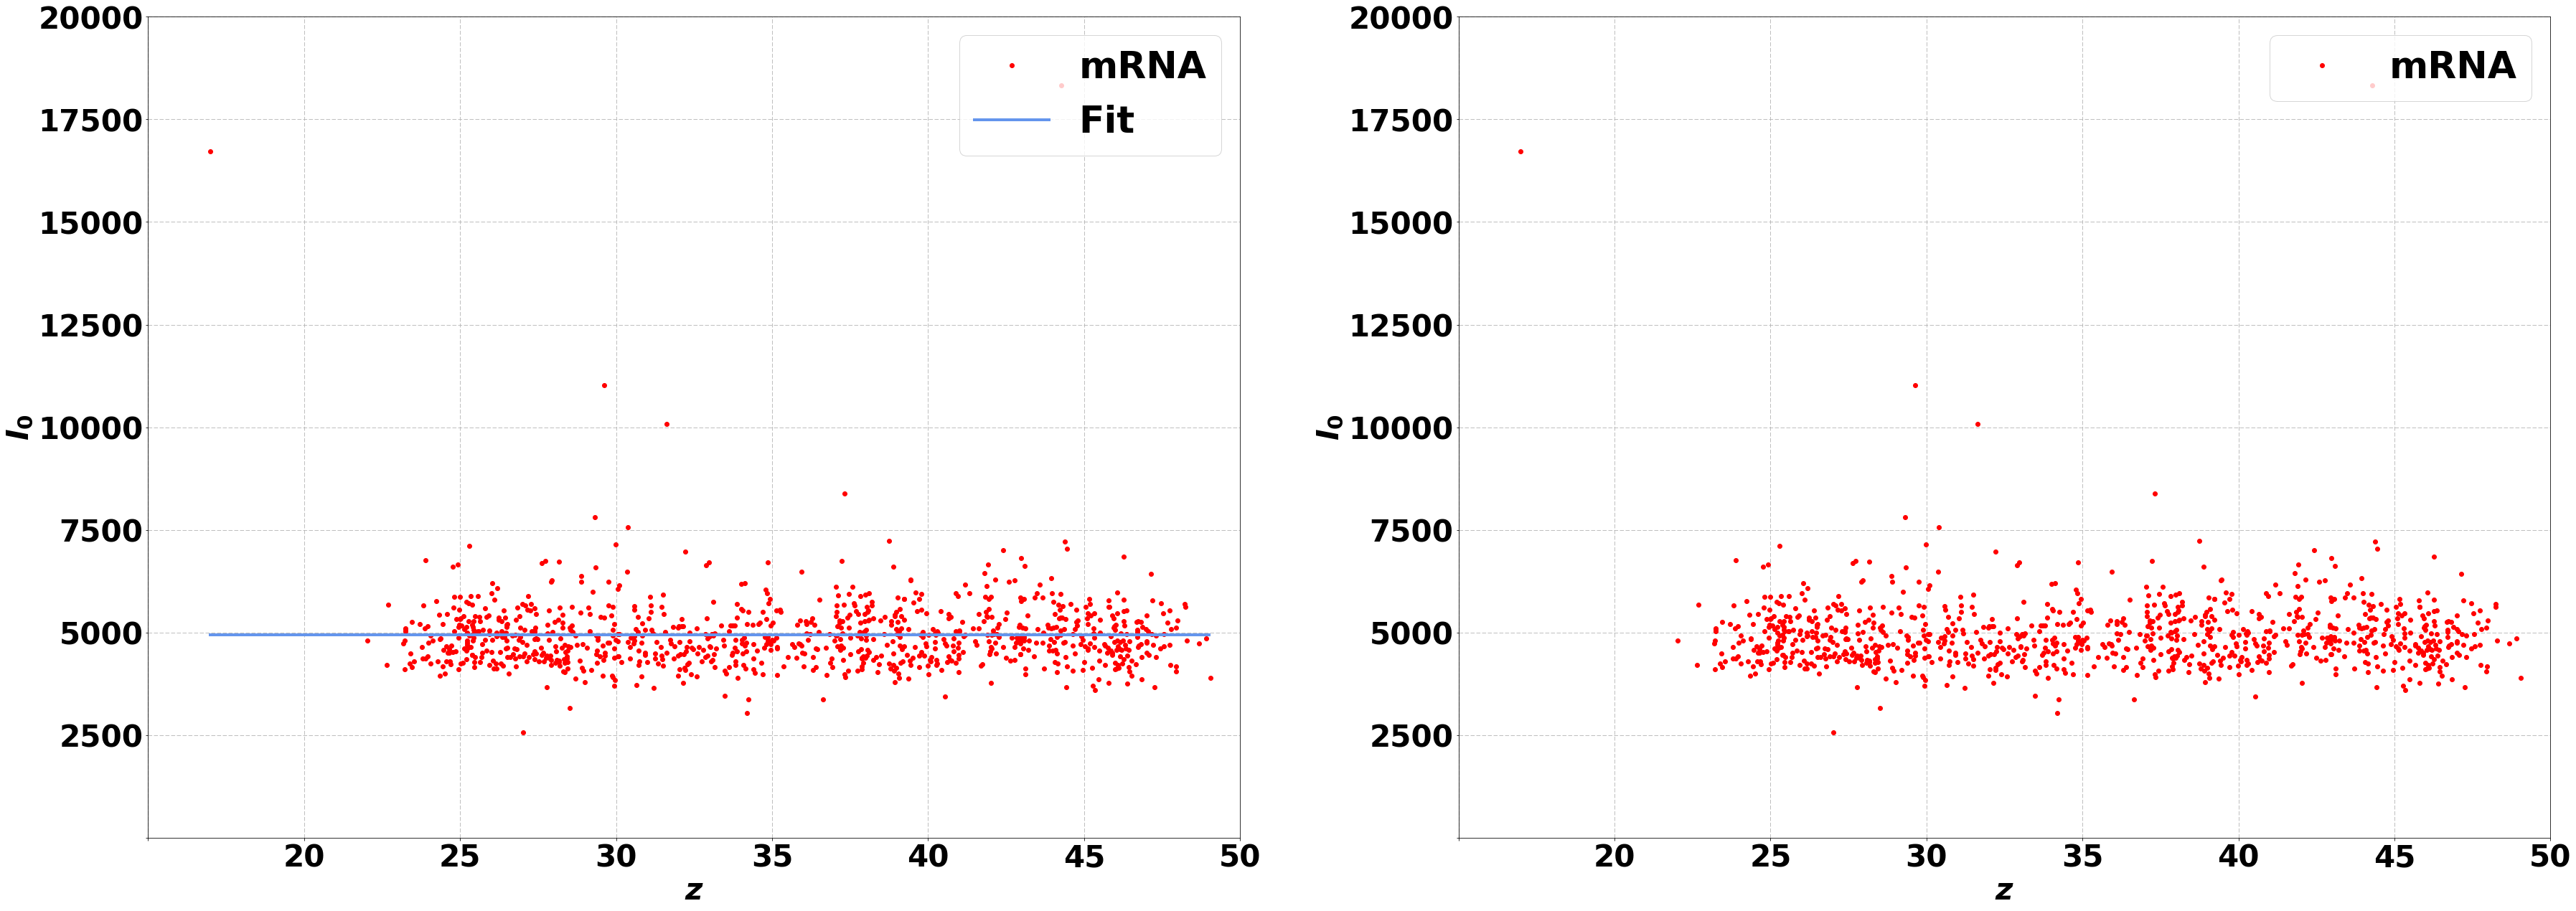

In [169]:
# generl setup for pretty images 
lines_params = np.zeros([1, 2])
channel_id = 1 # 1,2,3
folder_path = '/Volumes/Samsung_T3/2017-08-24-intronic-probes/' 
image = 'N2_dpy-23_ex_int_ama-1_016'

image_idx = 7

Ia_min, Ia_max = 0, 20000
za_min, za_max = 15, 50

plt.figure(figsize=(60,400))
params = {'font.size'   : 42,
        'legend.fontsize': 52}
plt.rcParams.update(params)

z, I = load_data(folder_path + image + '/results', image_idx, image, channel_id)
k, b, line_X, line_y = linear_fit(I, z)
I_adj = perform_correction(I, z, k, b) 
 
plot_fitting(I, I_adj, z, image_idx, line_X, line_y)
# plt.title(image + ' (series ' + str(idx).zfill(2) + ').tif', fontsize = 40)
plt.savefig(image + 'spots C = ' + str(channel_id) + '.pdf')

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


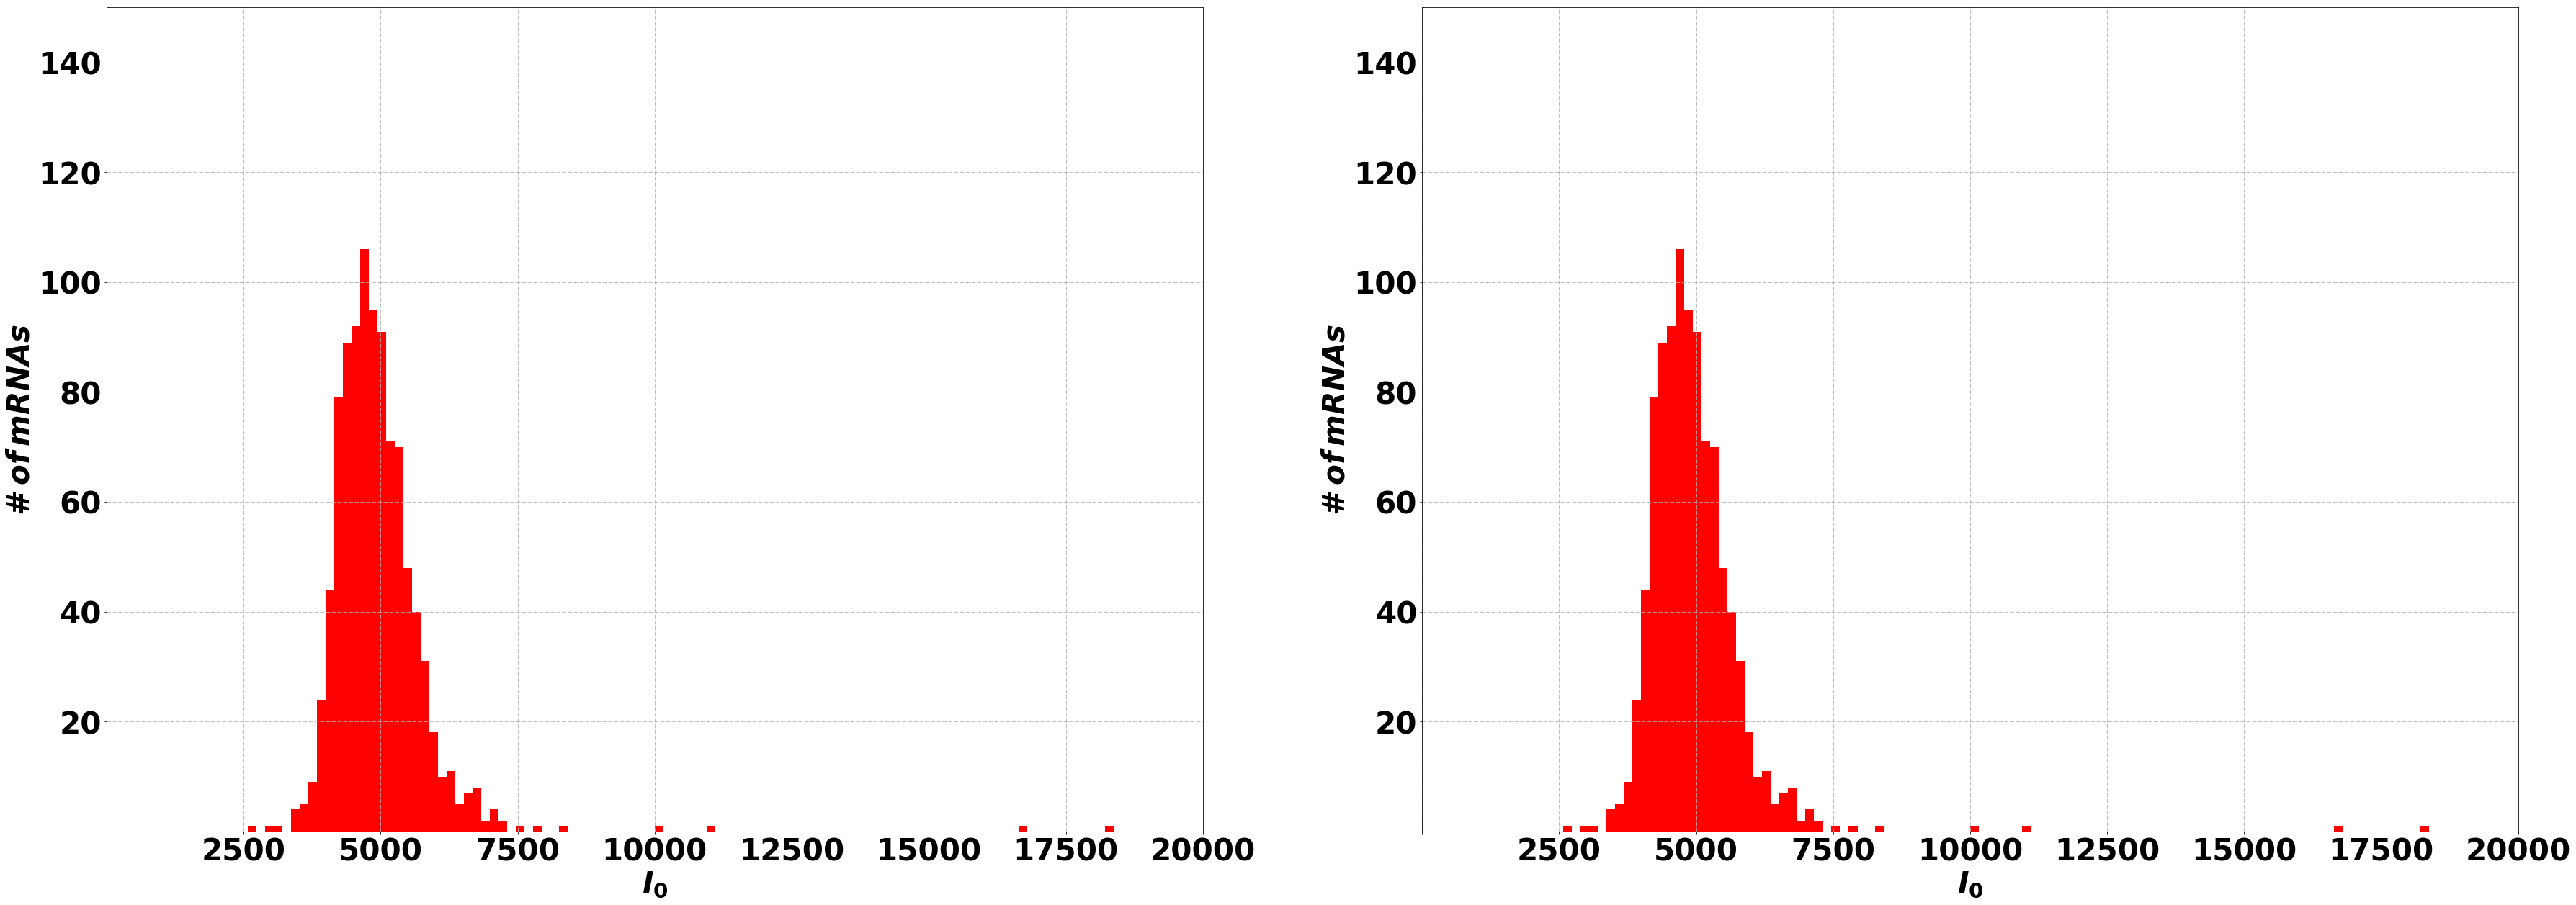

In [171]:
binwidth = 158
plt.figure(figsize=(60,400))
z, I = load_data(folder_path + image + '/results', image_idx, image, channel_id) 
k, b, line_X, line_y = linear_fit(I, z)
I_adj = perform_correction(I, z, k, b) 
plot_distribution(I, I_adj)
plt.savefig(image + ' hist C = ' + str(channel_id) + '.pdf')